/tmp/ipykernel_34930/2013821242.py:52: DtypeWarning: Columns (5,6,7,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  backlink_df = pd.read_csv(f, delimiter=' ', quotechar='"', header=None, escapechar='\\', encoding='utf-8', on_bad_lines='skip')


All url pairs: 453626


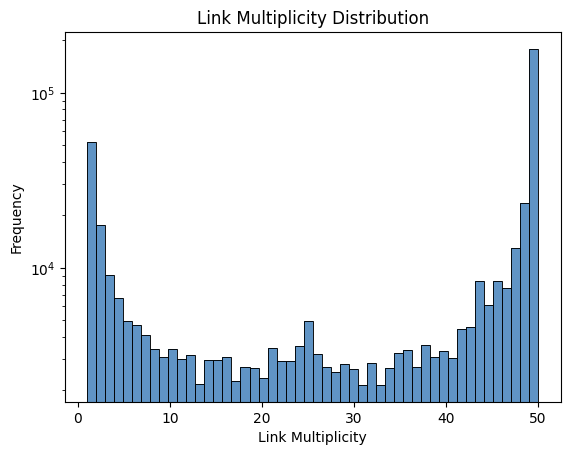

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
from urllib.parse import unquote
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.insert(0,'..')

def get_domain_unclean(url):
    return '/'.join(url.split('/')[:3])

def get_domain(url):
    return get_clean_url(url).split('/')[0]

_https = 'https://'
_http = 'http://'
_www = 'www.'
def get_clean_url(url):
    a_url = url
    if url[:len(_https)] == _https:
        a_url = url[len(_https):]
    elif url[:len(_http)] == _http:
        a_url = url[len(_http):]

    if a_url[:len(_www)] == _www:
        a_url = a_url[len(_www):]
    a_url = a_url.split('#')[0]
    a_url = a_url.split('?')[0]
    return a_url

def get_words_from_path(url_path):
    url_path = unquote(url_path)
    words = re.split(r'[-_/|%+]+', url_path)
    words = [word for word in words if not word.isdigit()]
    words = [word for word in words if word]
    return ' '.join(words    )

# filter out URLs that go to root domain
def is_article_url(url):
    return len(url.split('/')) > 3 and len(get_clean_url(url)) - len(get_domain(url)) > 10

def get_url_path(url):
    return '/'.join(url.split('/')[3:]).split('?')[0]

# def get_words_from_path(url_path):
#     # split by / _ - and remove any empty strings
#     return ' '.join(list(filter(None, re.split('/|_-', url_path))))

f = '../data/backlink_edges_unaggregated.txt'
backlink_df = pd.read_csv(f, delimiter=' ', quotechar='"', header=None, escapechar='\\', encoding='utf-8', on_bad_lines='skip')
backlink_df.columns = ["url_from","ahrefs_rank","domain_rating","ahrefs_top","ip_from","links_internal","links_external","page_size","encoding","title","language","url_to","first_seen", "fs_time","last_visited", "lv_time","prev_visited", "pv_time","original","redirect","alt","anchor","text_pre","text_post","http_code","url_from_first_seen", 'ffs_time',"first_origin","last_origin","link_type","nofollow","ugc","sponsored"]
print('All url pairs:', len(backlink_df))

backlink_df['source_domain'] = backlink_df['url_from'].apply(lambda url: get_domain_unclean(url))
backlink_df['dest_domain'] = backlink_df['url_to'].apply(lambda url: get_domain_unclean(url))
 
multiplicity_df = backlink_df.copy()
multiplicity_df['count'] = multiplicity_df.groupby(['source_domain', 'url_to'])['url_to'].transform('count')
multiplicity_df['count_clipped'] = multiplicity_df['count'].clip(lower=1, upper=50)
multiplicity_df.hist('count_clipped', bins=50)
multiplicity_df['count_clipped'] = multiplicity_df['count'].clip(lower=1, upper=50)

sns.histplot(data=multiplicity_df, x='count_clipped', color='#779ECB')
plt.xlabel('Link Multiplicity')
plt.ylabel('Frequency')
plt.title('Link Multiplicity Distribution')
plt.grid(False)
plt.yscale('log')
plt.savefig('../results/link_multiplicity.png', dpi=300, bbox_inches='tight')

In [48]:
def get_domain_clean(url):
    if 'http' == url[:4]:
        url = url.split('//')[1]
    return url.split('/')[0]

def domain_root(url):
    parts = get_domain_clean(url).split('.')
    if len(parts) >= 3 and ((len(parts[-2]) == 2 and parts[-2] not in ['gq', 'dw', 'nj', 'gp', 'bt', 'rt', 'dn']) or parts[-2] in ['com','org']):
        return ('.'.join(parts[len(parts) - 3:]), parts[len(parts) - 3])
    return ('.'.join(parts[len(parts) - 2:]), parts[len(parts) - 2])

def find_url_from_root(url, url_list):
    full_root, partial_root = domain_root(url)
    if full_root in url_list:
        return [full_root]

    urls = []
    for u in url_list:
        if partial_root in u:
            urls.append(u)
    return urls
# if 'label' in attributes_df.columns:
#     attributes_df.drop(['label'], axis=1, inplace=True)
attributes_df = pd.read_csv('../data/filtered_attrs.csv')
# convert url to lower case
attributes_df['url'] = attributes_df['url'].str.lower()
multiplicity_df['candidate_dest_domains'] = multiplicity_df['url_to'].apply(lambda x: find_url_from_root(x, attributes_df['url'].tolist()))
# set shortest candidate_dest_domains as label_domain column
multiplicity_df['label_domain'] = multiplicity_df['candidate_dest_domains'].apply(lambda x: min(x, key=len) if len(x) > 0 else '')
multiplicity_df.drop(['candidate_dest_domains'], axis=1, inplace=True)
multiplicity_df = multiplicity_df.merge(attributes_df[['url', 'label']], left_on='label_domain', right_on='url', how='inner').drop(['url'], axis=1)

/tmp/ipykernel_34930/7356122.py:11: FutureWarning: The provided callable <function mean at 0x7f1280578c20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  scaled_agg_scores = multiplicity_df[['label_domain', 'inv_count_scaled', 'label']].groupby('label_domain').aggregate({'inv_count_scaled':np.mean, 'label':(lambda x: np.round(np.mean(x)))}).reset_index()


<Axes: xlabel='label', ylabel='inv_count_scaled'>

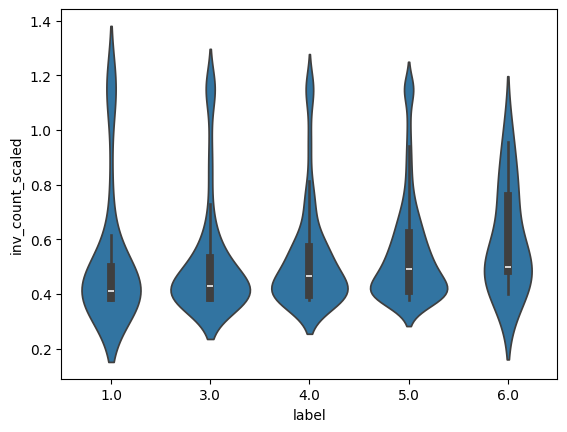

In [49]:
from sklearn.preprocessing import QuantileTransformer, StandardScaler, MinMaxScaler
import numpy as np

def custom_scaling(data, custom_mean, custom_std):
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    return data * custom_std + custom_mean

multiplicity_df['inv_count'] = multiplicity_df['count_clipped'].apply(lambda x: 1/x)
multiplicity_df['inv_count_scaled'] = custom_scaling(multiplicity_df['inv_count'].values.reshape(-1,1), 0.5, 0.25)
scaled_agg_scores = multiplicity_df[['label_domain', 'inv_count_scaled', 'label']].groupby('label_domain').aggregate({'inv_count_scaled':np.mean, 'label':(lambda x: np.round(np.mean(x)))}).reset_index()
sns.violinplot(data=scaled_agg_scores, x='label', y='inv_count_scaled')

In [50]:
import editdistance

def find_source_url_from_root(url, url_list):
    def substr(domain_list, domain_name):
        for domain in domain_list:
            if domain_name in domain:
                return domain
        return None
    domain = substr(url_list, url)
    if domain:
        return domain

    # minimum edit distance between full_root and urls in url_list
    min_dist = 100
    min_dist_url = ''
    for u in url_list:
        dist = editdistance.eval(url, u)
        if dist < min_dist:
            min_dist = dist
            min_dist_url = u

    return min_dist_url


reduced_source_names = [x.split('/')[0] for x in pd.read_csv('../data/filtered_backlinks.csv')['domain_from'].unique()]
multiplicity_df['source_domain_clean'] = multiplicity_df['url_from'].apply(lambda x: get_domain_clean(x))
source_domains = multiplicity_df['source_domain_clean'].unique()
source_domain_dict = {url:find_source_url_from_root(url, reduced_source_names) for url in source_domains}
# set shortest candidate_dest_domains as label_domain column
multiplicity_df['source_domain'] = multiplicity_df['source_domain_clean'].apply(lambda x: source_domain_dict[x])

0.5 2.5


/tmp/ipykernel_34930/3330626480.py:8: FutureWarning: The provided callable <function mean at 0x7f1280578c20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  scaled_agg_scores_grouped = multiplicity_df[['label_domain', 'source_domain', 'inv_count_scaled', 'label']].groupby(['label_domain', 'source_domain']).aggregate({'inv_count_scaled':np.mean, 'label':(lambda x: np.round(np.mean(x)))}).reset_index()
/tmp/ipykernel_34930/3330626480.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=scaled_agg_scores_grouped, x='color', y='inv_count_scaled', palette=colors)


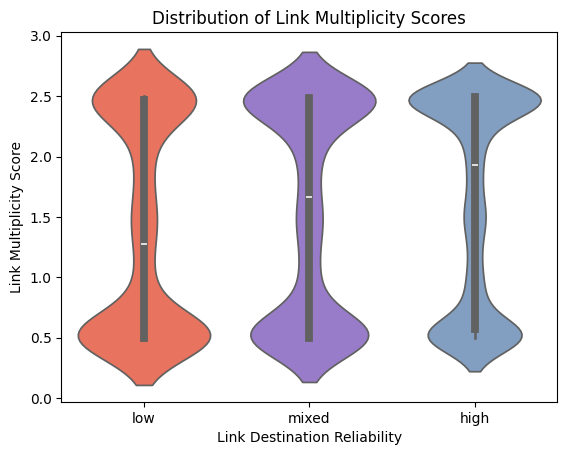

In [59]:
import matplotlib.pyplot as plt

mean = 1.5
multiplicity_df['count_clipped'] = multiplicity_df['count'].clip(lower=1, upper=50)
multiplicity_df['inv_count_scaled'] = custom_scaling(multiplicity_df['count_clipped'].values.reshape(-1,1))
multiplicity_df['inv_count_scaled'] = mean - multiplicity_df['inv_count_scaled']#.clip(lower=0, upper=1)
print(multiplicity_df['inv_count_scaled'].min(), multiplicity_df['inv_count_scaled'].max())
scaled_agg_scores_grouped = multiplicity_df[['label_domain', 'source_domain', 'inv_count_scaled', 'label']].groupby(['label_domain', 'source_domain']).aggregate({'inv_count_scaled':np.mean, 'label':(lambda x: np.round(np.mean(x)))}).reset_index()
scaled_agg_scores_grouped.to_csv('../results/multiplicity_scores.csv', index=False)

scaled_agg_scores_grouped['color'] = scaled_agg_scores_grouped['label'].apply(lambda l: l +2 if l == 1 else (l-1 if l == 6 else l))
colors = ['tomato', '#966fd6', '#779ECB']
sns.violinplot(data=scaled_agg_scores_grouped, x='color', y='inv_count_scaled', palette=colors)
plt.title('Distribution of Link Multiplicity Scores')
plt.xlabel('Link Destination Reliability')
plt.ylabel('Link Multiplicity Score')
plt.xticks([0,1,2], ['low', 'mixed', 'high'])
plt.savefig('../results/multiplicity_violin.png', dpi=300, bbox_inches='tight')

In [52]:
from sklearn.preprocessing import QuantileTransformer, StandardScaler, MinMaxScaler
import numpy as np

def custom_scaling(data):
    scaler = MinMaxScaler((-1, 1))
    data = scaler.fit_transform(data)
    return data

for mean_ in np.arange(1, 2.01, 0.1):
    multiplicity_df['count_clipped'] = multiplicity_df['count'].clip(lower=1, upper=50)
    multiplicity_df['inv_count_scaled'] = custom_scaling(multiplicity_df['count_clipped'].values.reshape(-1,1))
    multiplicity_df['inv_count_scaled'] = mean_ - multiplicity_df['inv_count_scaled']#.clip(lower=0, upper=1)
    print(multiplicity_df['inv_count_scaled'].min(), multiplicity_df['inv_count_scaled'].max())
    scaled_agg_scores_grouped = multiplicity_df[['label_domain', 'source_domain', 'inv_count_scaled', 'label']].groupby(['label_domain', 'source_domain']).aggregate({'inv_count_scaled':np.mean, 'label':(lambda x: np.round(np.mean(x)))}).reset_index()
    scaled_agg_scores_grouped.to_csv('../results/multiplicity/scores'+str(mean_)+'.csv', index=False)

0.0 2.0


/tmp/ipykernel_34930/913412316.py:14: FutureWarning: The provided callable <function mean at 0x7f1280578c20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  scaled_agg_scores_grouped = multiplicity_df[['label_domain', 'source_domain', 'inv_count_scaled', 'label']].groupby(['label_domain', 'source_domain']).aggregate({'inv_count_scaled':np.mean, 'label':(lambda x: np.round(np.mean(x)))}).reset_index()


0.10000000000000009 2.1


/tmp/ipykernel_34930/913412316.py:14: FutureWarning: The provided callable <function mean at 0x7f1280578c20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  scaled_agg_scores_grouped = multiplicity_df[['label_domain', 'source_domain', 'inv_count_scaled', 'label']].groupby(['label_domain', 'source_domain']).aggregate({'inv_count_scaled':np.mean, 'label':(lambda x: np.round(np.mean(x)))}).reset_index()


0.20000000000000018 2.2


/tmp/ipykernel_34930/913412316.py:14: FutureWarning: The provided callable <function mean at 0x7f1280578c20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  scaled_agg_scores_grouped = multiplicity_df[['label_domain', 'source_domain', 'inv_count_scaled', 'label']].groupby(['label_domain', 'source_domain']).aggregate({'inv_count_scaled':np.mean, 'label':(lambda x: np.round(np.mean(x)))}).reset_index()


0.30000000000000027 2.3000000000000003


/tmp/ipykernel_34930/913412316.py:14: FutureWarning: The provided callable <function mean at 0x7f1280578c20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  scaled_agg_scores_grouped = multiplicity_df[['label_domain', 'source_domain', 'inv_count_scaled', 'label']].groupby(['label_domain', 'source_domain']).aggregate({'inv_count_scaled':np.mean, 'label':(lambda x: np.round(np.mean(x)))}).reset_index()


0.40000000000000036 2.4000000000000004


/tmp/ipykernel_34930/913412316.py:14: FutureWarning: The provided callable <function mean at 0x7f1280578c20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  scaled_agg_scores_grouped = multiplicity_df[['label_domain', 'source_domain', 'inv_count_scaled', 'label']].groupby(['label_domain', 'source_domain']).aggregate({'inv_count_scaled':np.mean, 'label':(lambda x: np.round(np.mean(x)))}).reset_index()


0.5000000000000004 2.5000000000000004


/tmp/ipykernel_34930/913412316.py:14: FutureWarning: The provided callable <function mean at 0x7f1280578c20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  scaled_agg_scores_grouped = multiplicity_df[['label_domain', 'source_domain', 'inv_count_scaled', 'label']].groupby(['label_domain', 'source_domain']).aggregate({'inv_count_scaled':np.mean, 'label':(lambda x: np.round(np.mean(x)))}).reset_index()


0.6000000000000005 2.6000000000000005


/tmp/ipykernel_34930/913412316.py:14: FutureWarning: The provided callable <function mean at 0x7f1280578c20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  scaled_agg_scores_grouped = multiplicity_df[['label_domain', 'source_domain', 'inv_count_scaled', 'label']].groupby(['label_domain', 'source_domain']).aggregate({'inv_count_scaled':np.mean, 'label':(lambda x: np.round(np.mean(x)))}).reset_index()


0.7000000000000006 2.7000000000000006


/tmp/ipykernel_34930/913412316.py:14: FutureWarning: The provided callable <function mean at 0x7f1280578c20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  scaled_agg_scores_grouped = multiplicity_df[['label_domain', 'source_domain', 'inv_count_scaled', 'label']].groupby(['label_domain', 'source_domain']).aggregate({'inv_count_scaled':np.mean, 'label':(lambda x: np.round(np.mean(x)))}).reset_index()


0.8000000000000007 2.8000000000000007


/tmp/ipykernel_34930/913412316.py:14: FutureWarning: The provided callable <function mean at 0x7f1280578c20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  scaled_agg_scores_grouped = multiplicity_df[['label_domain', 'source_domain', 'inv_count_scaled', 'label']].groupby(['label_domain', 'source_domain']).aggregate({'inv_count_scaled':np.mean, 'label':(lambda x: np.round(np.mean(x)))}).reset_index()


0.9000000000000008 2.900000000000001


/tmp/ipykernel_34930/913412316.py:14: FutureWarning: The provided callable <function mean at 0x7f1280578c20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  scaled_agg_scores_grouped = multiplicity_df[['label_domain', 'source_domain', 'inv_count_scaled', 'label']].groupby(['label_domain', 'source_domain']).aggregate({'inv_count_scaled':np.mean, 'label':(lambda x: np.round(np.mean(x)))}).reset_index()


1.0000000000000009 3.000000000000001


/tmp/ipykernel_34930/913412316.py:14: FutureWarning: The provided callable <function mean at 0x7f1280578c20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  scaled_agg_scores_grouped = multiplicity_df[['label_domain', 'source_domain', 'inv_count_scaled', 'label']].groupby(['label_domain', 'source_domain']).aggregate({'inv_count_scaled':np.mean, 'label':(lambda x: np.round(np.mean(x)))}).reset_index()


Multplicity Weighting: 1.0
Running experiment: multplicity weighting
Multplicity Weighting: 1.1


/home/pcarragh/dev/link_scheme_removal/interventions/../regressions/intervention_eval.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['label'].replace({1:3, 6:5}, inplace=True)


Running experiment: multplicity weighting
Multplicity Weighting: 1.2000000000000002


/home/pcarragh/dev/link_scheme_removal/interventions/../regressions/intervention_eval.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['label'].replace({1:3, 6:5}, inplace=True)


Running experiment: multplicity weighting
Multplicity Weighting: 1.3000000000000003


/home/pcarragh/dev/link_scheme_removal/interventions/../regressions/intervention_eval.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['label'].replace({1:3, 6:5}, inplace=True)


Running experiment: multplicity weighting
Multplicity Weighting: 1.4000000000000004


/home/pcarragh/dev/link_scheme_removal/interventions/../regressions/intervention_eval.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['label'].replace({1:3, 6:5}, inplace=True)


Running experiment: multplicity weighting
Multplicity Weighting: 1.5000000000000004


/home/pcarragh/dev/link_scheme_removal/interventions/../regressions/intervention_eval.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['label'].replace({1:3, 6:5}, inplace=True)


Running experiment: multplicity weighting
Multplicity Weighting: 1.6000000000000005


/home/pcarragh/dev/link_scheme_removal/interventions/../regressions/intervention_eval.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['label'].replace({1:3, 6:5}, inplace=True)


Running experiment: multplicity weighting
Multplicity Weighting: 1.7000000000000006


/home/pcarragh/dev/link_scheme_removal/interventions/../regressions/intervention_eval.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['label'].replace({1:3, 6:5}, inplace=True)


Running experiment: multplicity weighting
Multplicity Weighting: 1.8000000000000007


/home/pcarragh/dev/link_scheme_removal/interventions/../regressions/intervention_eval.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['label'].replace({1:3, 6:5}, inplace=True)


Running experiment: multplicity weighting
Multplicity Weighting: 1.9000000000000008


/home/pcarragh/dev/link_scheme_removal/interventions/../regressions/intervention_eval.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['label'].replace({1:3, 6:5}, inplace=True)


Running experiment: multplicity weighting
Multplicity Weighting: 2.000000000000001


/home/pcarragh/dev/link_scheme_removal/interventions/../regressions/intervention_eval.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['label'].replace({1:3, 6:5}, inplace=True)


Running experiment: multplicity weighting


/home/pcarragh/dev/link_scheme_removal/interventions/../regressions/intervention_eval.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['label'].replace({1:3, 6:5}, inplace=True)


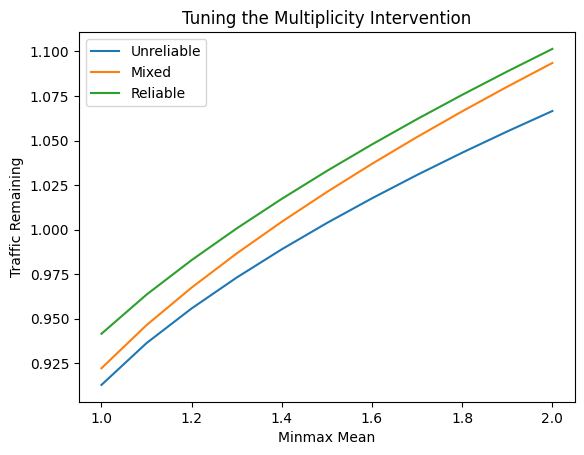

In [58]:
import interventions.backlink_relevance_combined as intervention
import regressions.intervention_eval as regression
from importlib import reload
reload(intervention)
reload(regression)

traffic_df = pd.read_csv('../data/traffic.csv')
attribute_df = pd.read_csv('../data/filtered_attrs.csv')
traffic_df = traffic_df[traffic_df['url'].isin(attribute_df['url'])]

urls_to_remove = ['youtube.com', 'facebook.com']
for url in urls_to_remove:
    traffic_df = traffic_df[~traffic_df['url'].str.contains(url)]
    attribute_df = attribute_df[~attribute_df['url'].str.contains(url)]

traffic_df.reset_index(drop=True, inplace=True)
attribute_df.reset_index(drop=True, inplace=True)

results = []
for mean_ in np.arange(1, 2.01, 0.1):
    print('Multplicity Weighting:', mean_)
    scores_path = '../results/multiplicity/scores'+str(mean_)+'.csv'

    multiplicity_experiments = {
        'multplicity weighting': intervention.run_combined_intervention(link_scheme_removal=False, multiplicity_weighting=True, multiplicity_file = scores_path, attribute_df=attribute_df)[0],
    }
    regression_results, _= regression.run_regression(traffic_df, attribute_df, reg_var = 'traffic', experiments=multiplicity_experiments)
    results.append(regression_results)

means = np.arange(1, 2.01, 0.1)
unreliable = [x[3][0] for x in results]
mixed = [x[4][0] for x in results]
reliable = [x[5][0] for x in results]

import matplotlib.pyplot as plt
plt.plot(means, unreliable, label='Unreliable')
plt.plot(means, mixed, label='Mixed')
plt.plot(means, reliable, label='Reliable')
plt.legend()
plt.xlabel('Minmax Mean')
plt.ylabel('Traffic Remaining')
plt.title('Tuning the Multiplicity Intervention')
plt.savefig('../results/multiplicity_tuning.png', dpi=300)

In [40]:
traffic_df = pd.read_csv('../data/traffic.csv')
attribute_df = pd.read_csv('../data/filtered_attrs.csv')
# attribute_df['url'] = attribute_df['url'].apply(lambda x: x.split('/')[0])
# traffic_df['url'] = traffic_df['url'].str.lower()
# traffic_df = traffic_df[traffic_df['url'].isin(attribute_df['url'])]
# attribute_df.count()
join_df = traffic_df.join(attribute_df.set_index('url'), on='url', how='inner')
join_df.count()

# get everything in traffic_df that is not in attribute_df
missing = attribute_df[~attribute_df['url'].isin(traffic_df['url'])]
missing


,url,label,source,backlinks,refpages,pages,valid_pages,text,image,nofollow,...,edu,rss,alternate,html_pages,links_internal,links_external,refdomains,refclass_c,refips,linked_root_domains
235,aspentimes.com/snowmass,5,MBFC,1.312335e+06,938182,1840920,1840915,1.306955e+06,33192,700818,...,1362,133,3,251929,11924293,4697050,39235,7862,13198,5779
466,cbsnews.com/pittsburgh,5,MBFC,6.611970e+07,32152690,5439480,5439062,6.312793e+07,5093874,10001123,...,409007,27641,386861,2390783,83749898,35804867,531047,89743,245946,98155
472,cecildaily.com/susquehanna_press,5,MBFC,1.767680e+05,108014,4922,4922,1.761050e+05,1991,37343,...,240,93,13,644,22813,9175,5035,2677,4414,107
762,deltanews.tv/wnbd,5,MBFC,1.152500e+04,8842,2387,2387,1.101000e+04,1344,2645,...,105,8,0,145,12245,2546,1513,994,1209,49
931,facebook.com/conservativepoliticstoday,3,MBFC-Q,1.068310e+11,85647056424,6597,6596,1.064830e+11,26674002012,10900691069,...,3330718386,470125,2214374,2801,154611,4284,55494866,760318,6537076,33
932,facebook.com/news,5,MBFC,1.068310e+11,85647056424,6597,6596,1.064830e+11,26674002012,10900691069,...,3330718386,470125,2214374,2801,154611,4284,55494866,760318,6537076,33
933,facebook.com/womensrightsnews,3,MBFC-Q,1.068310e+11,85647056424,6597,6596,1.064830e+11,26674002012,10900691069,...,3330718386,470125,2214374,2801,154611,4284,55494866,760318,6537076,33
1343,insideottawavalley.com/carletonplace-on,5,MBFC,1.985420e+05,81033,206199,205551,1.490180e+05,1529,26519,...,151,10,0,185773,2802628,2537582,2346,2322,6758,16680
1796,myheraldreview.com/news/willcox,5,MBFC,6.166800e+04,39894,19095,19092,6.093800e+04,1070,23900,...,449,21,4,12784,685062,92156,4397,2359,3404,630
2157,postregister.com/star,5,MBFC,3.119030e+05,256497,11807,11807,3.107050e+05,4640,248239,...,1114,235,4,1920,199628,47072,9243,4925,7625,274


In [45]:
url_map = {}
for url in missing['url']:
    url_map[url] = url.split('/')[0]
    
# attribute_df['url'] = attribute_df['url'].replace(lambda x: x.split('/')[0])
# use url_map to replace urls in attribute_df, default to existing value if not in url_map
attribute_df['url'] = attribute_df['url'].apply(lambda x: url_map.get(x, x))
attribute_df[~attribute_df['url'].isin(traffic_df['url'])]

,url,label,source,backlinks,refpages,pages,valid_pages,text,image,nofollow,...,edu,rss,alternate,html_pages,links_internal,links_external,refdomains,refclass_c,refips,linked_root_domains
931,facebook.com,3,MBFC-Q,1.068310e+11,85647056424,6597,6596,1.064830e+11,26674002012,10900691069,...,3330718386,470125,2214374,2801,154611,4284,55494866,760318,6537076,33
932,facebook.com,5,MBFC,1.068310e+11,85647056424,6597,6596,1.064830e+11,26674002012,10900691069,...,3330718386,470125,2214374,2801,154611,4284,55494866,760318,6537076,33
933,facebook.com,3,MBFC-Q,1.068310e+11,85647056424,6597,6596,1.064830e+11,26674002012,10900691069,...,3330718386,470125,2214374,2801,154611,4284,55494866,760318,6537076,33
1343,insideottawavalley.com,5,MBFC,1.985420e+05,81033,206199,205551,1.490180e+05,1529,26519,...,151,10,0,185773,2802628,2537582,2346,2322,6758,16680
3203,youtube.com,3,MBFC-Q,7.379810e+10,45520713374,6422878,6422873,6.431758e+10,16539559855,5866501892,...,2933751491,5175450,5475848,6403233,145979246,38372472,34797288,683952,4912447,24694


In [46]:
urls_to_remove = ['youtube.com', 'facebook.com']
for url in urls_to_remove:
    traffic_df = traffic_df[~traffic_df['url'].str.contains(url)]
    attribute_df = attribute_df[~attribute_df['url'].str.contains(url)]

attribute_df.dropna(inplace=True)

url                    3206
label                  3206
source                 3206
backlinks              3206
refpages               3206
pages                  3206
valid_pages            3206
text                   3206
image                  3206
nofollow               3206
ugc                    3206
sponsored              3206
dofollow               3206
redirect               3206
canonical              3206
gov                    3206
edu                    3206
rss                    3206
alternate              3206
html_pages             3206
links_internal         3206
links_external         3206
refdomains             3206
refclass_c             3206
refips                 3206
linked_root_domains    3206
dtype: int64